In [28]:
import sys
print(sys.executable)

d:\Kuliah Semester 4\Natural Language Processing\Project Kelompok\.venv\Scripts\python.exe


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

normalize = transforms.Normalize((0.5,), (0.5,))

normalized_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize
])

augment_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

transform_variations = {
    "Base": base_transform,
    "Normalized": normalized_transform,
    "Normalized + Augment": augment_transform,
    "Normalized + Augment + Regularize": augment_transform  # regularization in model, not transform
}

def train_fine_tuning(model, train_loader, val_loader, epochs=10, lr=1e-4, regularize=False, history=None):
    
    for param in model.parameters():
        param.requires_grad = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4 if regularize else 0.0)

    if history is None or not all(k in history for k in ['train_loss', 'val_loss', 'train_acc', 'val_acc']):
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
           images, labels = images.to(device), labels.to(device)
           optimizer.zero_grad()
           outputs = model(images)
           loss = criterion(outputs, labels)
           loss.backward()
           optimizer.step()

           running_loss += loss.item()
           _, preds = torch.max(outputs, 1)
           correct_train += (preds == labels).sum().item()
           total_train += labels.size(0)
    
        avg_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train/total_train
        
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_preds = torch.max(val_outputs, 1)
                correct_val += (val_preds == val_labels).sum().item()
                total_val += val_labels.size(0)
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        history['train_loss'].append(avg_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        

        print(f'epoch [{epoch+1}/{epochs}] - train loss: {avg_loss:.4f} | val loss: {avg_val_loss:.2f}% | train acc: {train_acc:.2f}% | val acc: {val_acc:.2f}%')
        
    return history


def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    acc = 100 * correct / total
    return acc, np.array(all_preds), np.array(all_labels)



In [32]:
# #model
# model = models.resnet18(weights='IMAGENET1K_V1')
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 10)
# model = model.to(device)

In [33]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach().clone()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach().clone()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_image, target_class=None):
        self.model.zero_grad()
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        loss = output[0, target_class]
        loss.backward()

        if self.gradients is None:
            raise RuntimeError("Gradients were not captured. Check target_layer or hooks.")

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1).squeeze()
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        cam = cam.cpu().numpy()
        return cam, target_class


In [34]:
def gradcam_evaluate(model, data):
    model.eval()
    data = data.to(device)
    data.requires_grad_()  # ✅ needed for Grad-CAM
    target_layer = model.layer4[-1]  # example for ResNet
    grad_cam = GradCAM(model, target_layer)
    cam, cls = grad_cam.generate(data)
    return cam, cls

In [35]:
def plot_training_progress(history_dict):
    """
    history_dict = {
        "Baseline": {"train_acc": [...], "val_acc": [...]},
        "Normalized": {"train_acc": [...], "val_acc": [...]},
        "Augment + Normalize": {...},
        ...
    }
    """
    plt.figure(figsize=(8,6))
    for name, history in history_dict.items():
        plt.plot(history["val_acc"], label=f"{name} (Val)")
        plt.plot(history["train_acc"], '--', alpha=0.5, label=f"{name} (Train)")
    
    plt.title("Training Progress Across Model Variations")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


🔹 Running Base dataset
epoch [1/10] - train loss: 0.1242 | val loss: 0.04% | train acc: 96.27% | val acc: 98.58%
epoch [2/10] - train loss: 0.0261 | val loss: 0.04% | train acc: 99.19% | val acc: 98.87%
epoch [3/10] - train loss: 0.0178 | val loss: 0.03% | train acc: 99.44% | val acc: 99.01%
epoch [4/10] - train loss: 0.0123 | val loss: 0.04% | train acc: 99.60% | val acc: 98.83%
epoch [5/10] - train loss: 0.0117 | val loss: 0.04% | train acc: 99.63% | val acc: 99.06%
epoch [6/10] - train loss: 0.0118 | val loss: 0.04% | train acc: 99.64% | val acc: 99.10%
epoch [7/10] - train loss: 0.0099 | val loss: 0.03% | train acc: 99.67% | val acc: 99.33%
epoch [8/10] - train loss: 0.0079 | val loss: 0.04% | train acc: 99.75% | val acc: 99.13%
epoch [9/10] - train loss: 0.0084 | val loss: 0.04% | train acc: 99.73% | val acc: 99.22%
epoch [10/10] - train loss: 0.0064 | val loss: 0.04% | train acc: 99.79% | val acc: 99.03%
✅ Base Test Accuracy: 98.72%


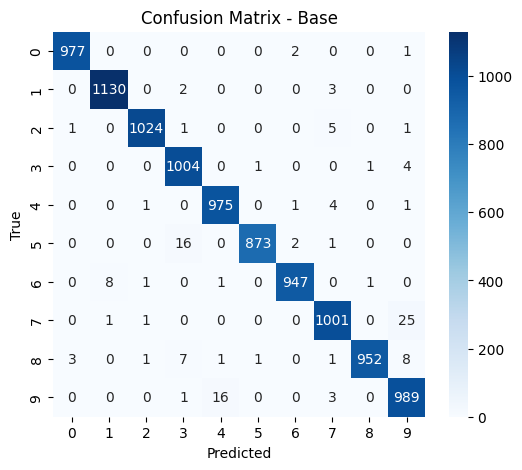

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_31324\730305514.py:54: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


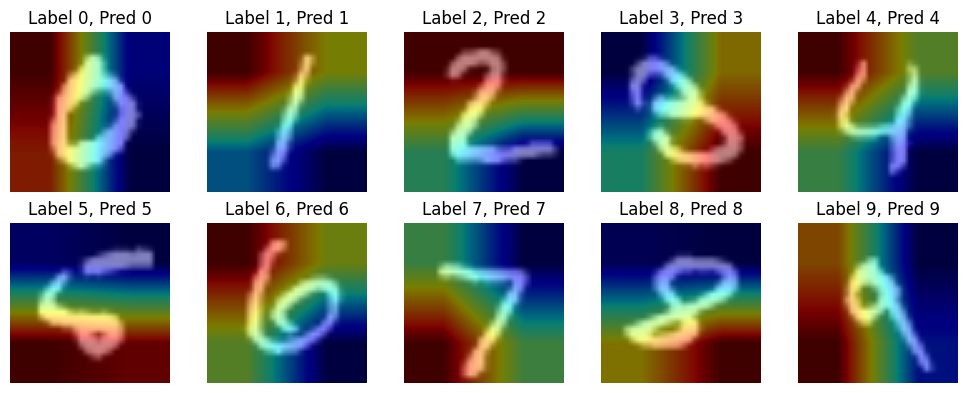


🔹 Running Normalized dataset
epoch [1/10] - train loss: 0.1284 | val loss: 0.04% | train acc: 96.10% | val acc: 98.73%
epoch [2/10] - train loss: 0.0286 | val loss: 0.04% | train acc: 99.11% | val acc: 98.62%
epoch [3/10] - train loss: 0.0166 | val loss: 0.03% | train acc: 99.49% | val acc: 99.00%
epoch [4/10] - train loss: 0.0125 | val loss: 0.05% | train acc: 99.58% | val acc: 98.67%
epoch [5/10] - train loss: 0.0134 | val loss: 0.04% | train acc: 99.52% | val acc: 98.99%
epoch [6/10] - train loss: 0.0098 | val loss: 0.03% | train acc: 99.67% | val acc: 99.06%
epoch [7/10] - train loss: 0.0113 | val loss: 0.03% | train acc: 99.64% | val acc: 99.19%
epoch [8/10] - train loss: 0.0075 | val loss: 0.04% | train acc: 99.76% | val acc: 99.09%
epoch [9/10] - train loss: 0.0089 | val loss: 0.03% | train acc: 99.73% | val acc: 99.26%
epoch [10/10] - train loss: 0.0070 | val loss: 0.03% | train acc: 99.79% | val acc: 99.29%
✅ Normalized Test Accuracy: 99.38%


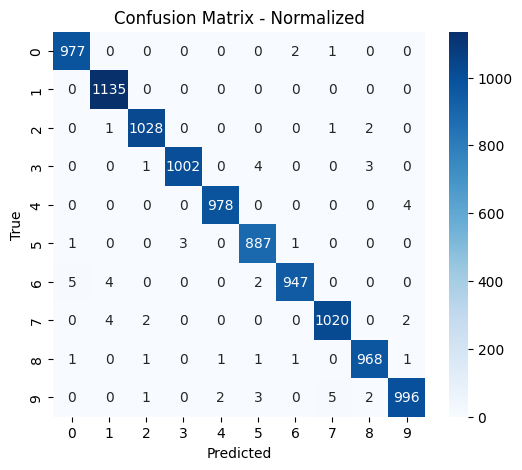

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_31324\730305514.py:54: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


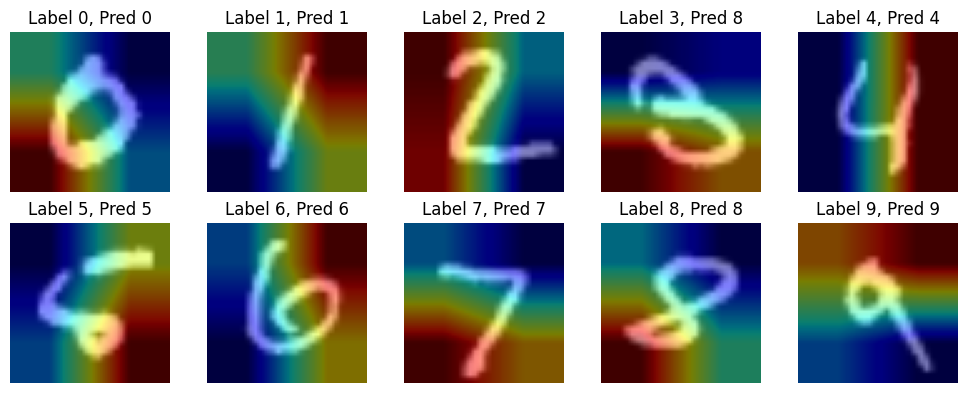


🔹 Running Normalized + Augment dataset
epoch [1/10] - train loss: 0.1879 | val loss: 0.07% | train acc: 94.24% | val acc: 97.89%
epoch [2/10] - train loss: 0.0642 | val loss: 0.05% | train acc: 98.02% | val acc: 98.18%
epoch [3/10] - train loss: 0.0474 | val loss: 0.05% | train acc: 98.49% | val acc: 98.43%
epoch [4/10] - train loss: 0.0370 | val loss: 0.04% | train acc: 98.83% | val acc: 98.80%
epoch [5/10] - train loss: 0.0326 | val loss: 0.04% | train acc: 98.95% | val acc: 98.84%
epoch [6/10] - train loss: 0.0316 | val loss: 0.04% | train acc: 99.03% | val acc: 98.73%
epoch [7/10] - train loss: 0.0260 | val loss: 0.04% | train acc: 99.15% | val acc: 98.92%
epoch [8/10] - train loss: 0.0248 | val loss: 0.06% | train acc: 99.24% | val acc: 98.36%
epoch [9/10] - train loss: 0.0212 | val loss: 0.04% | train acc: 99.31% | val acc: 98.77%
epoch [10/10] - train loss: 0.0216 | val loss: 0.04% | train acc: 99.33% | val acc: 99.01%
✅ Normalized + Augment Test Accuracy: 99.11%


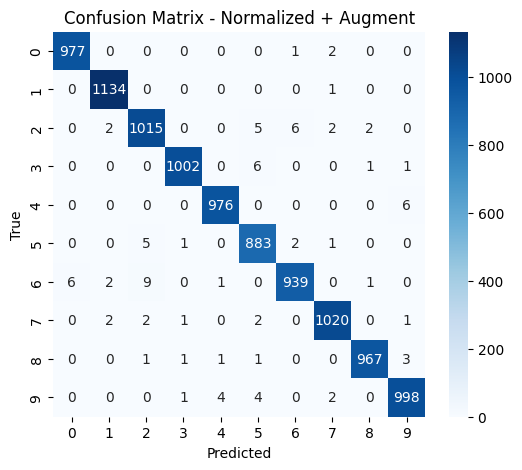

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_31324\730305514.py:54: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


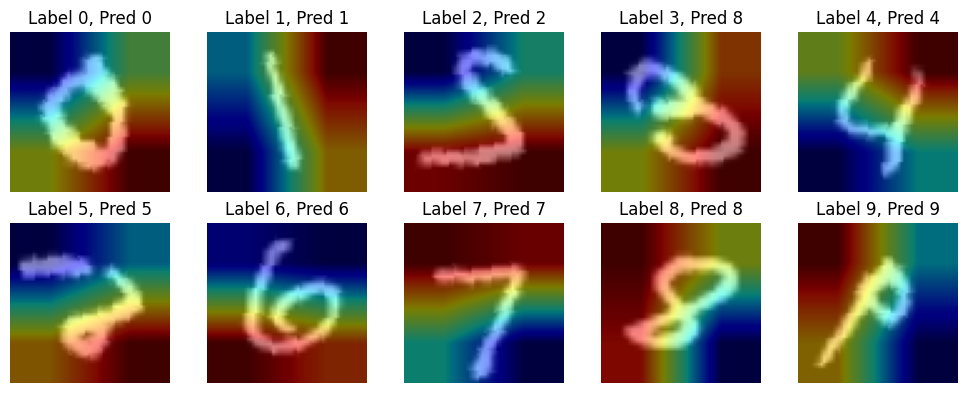


🔹 Running Normalized + Augment + Regularize dataset
epoch [1/10] - train loss: 0.2773 | val loss: 0.08% | train acc: 91.41% | val acc: 97.47%
epoch [2/10] - train loss: 0.0773 | val loss: 0.06% | train acc: 97.68% | val acc: 98.19%
epoch [3/10] - train loss: 0.0530 | val loss: 0.05% | train acc: 98.37% | val acc: 98.42%
epoch [4/10] - train loss: 0.0439 | val loss: 0.04% | train acc: 98.70% | val acc: 98.97%
epoch [5/10] - train loss: 0.0376 | val loss: 0.04% | train acc: 98.83% | val acc: 98.76%
epoch [6/10] - train loss: 0.0326 | val loss: 0.04% | train acc: 99.03% | val acc: 98.96%
epoch [7/10] - train loss: 0.0305 | val loss: 0.04% | train acc: 99.07% | val acc: 98.78%
epoch [8/10] - train loss: 0.0250 | val loss: 0.05% | train acc: 99.19% | val acc: 98.71%
epoch [9/10] - train loss: 0.0256 | val loss: 0.03% | train acc: 99.20% | val acc: 98.98%
epoch [10/10] - train loss: 0.0246 | val loss: 0.03% | train acc: 99.26% | val acc: 99.16%
✅ Normalized + Augment + Regularize Test Accur

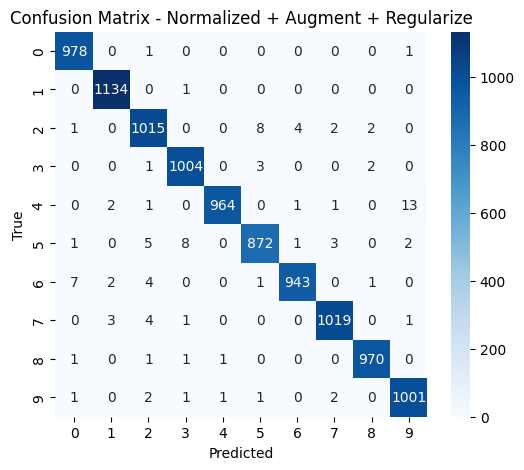

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_31324\730305514.py:54: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


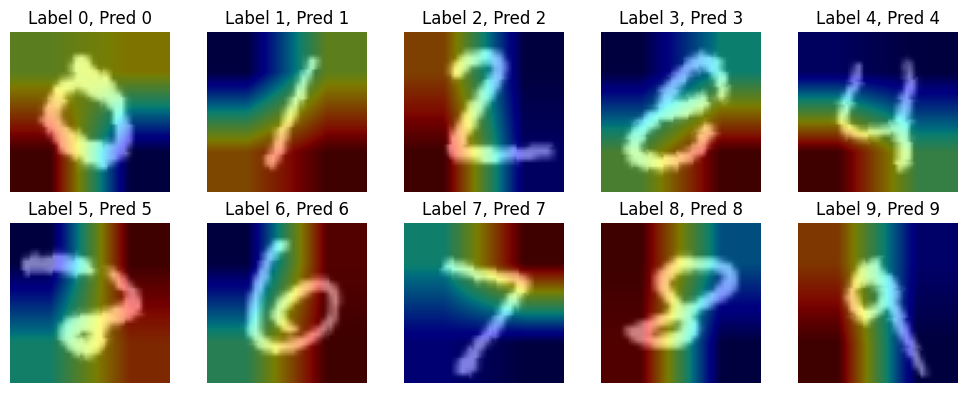

In [36]:
results = []
histories = {}  # store per-variation accuracy history

for variation_name, transform in transform_variations.items():
    print(f"\n🔹 Running {variation_name} dataset")

    # ---- Dataset split ----
    dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    # ---- Model setup ----
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Sequential(
        nn.Dropout(0.5 if "Regularize" in variation_name else 0.0),
        nn.Linear(model.fc.in_features, 10)
    )
    model = model.to(device)

    # ---- Train & Track ----
    history = {}
    history = train_fine_tuning(model, train_loader, val_loader, epochs=10, lr=1e-4, history=history)

    # ---- Evaluate on Test Set ----
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    test_acc, preds, labels = evaluate(model, test_loader)
    print(f"✅ {variation_name} Test Accuracy: {test_acc:.2f}%")

    # ---- Confusion Matrix ----
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {variation_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ---- Store results ----
    results.append({"Variation": variation_name, "Accuracy": test_acc})
    histories[variation_name] = history

    # ---- Grad-CAM Visualizations ----
    grad_cam = GradCAM(model, model.layer4[-1].conv2)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
    axes_flat = axes.flatten()

    for i in range(10):
        ax = axes_flat[i]
        idx = np.where(np.array(test_dataset.targets) == i)[0][0]
        img, _ = test_dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)
        input_tensor.requires_grad_()
        cam, cls = grad_cam.generate(input_tensor)
        cam_resized = cv2.resize(cam, (img.shape[2], img.shape[1]))

        ax.imshow(img.squeeze().cpu().numpy(), cmap="gray")
        ax.imshow(cam_resized, cmap="jet", alpha=0.5)
        ax.set_title(f"Label {i}, Pred {cls}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

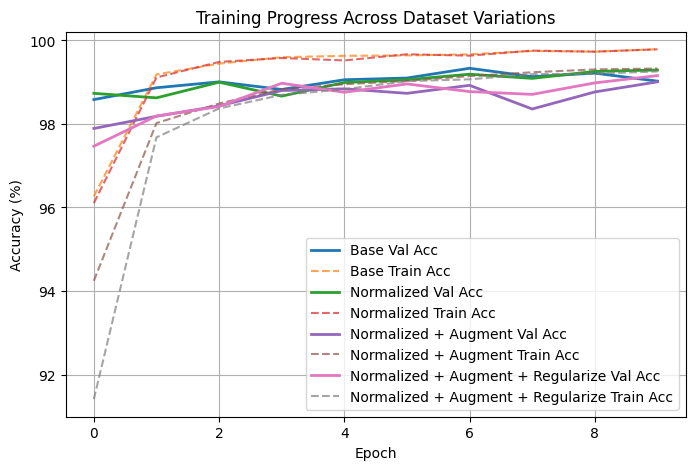

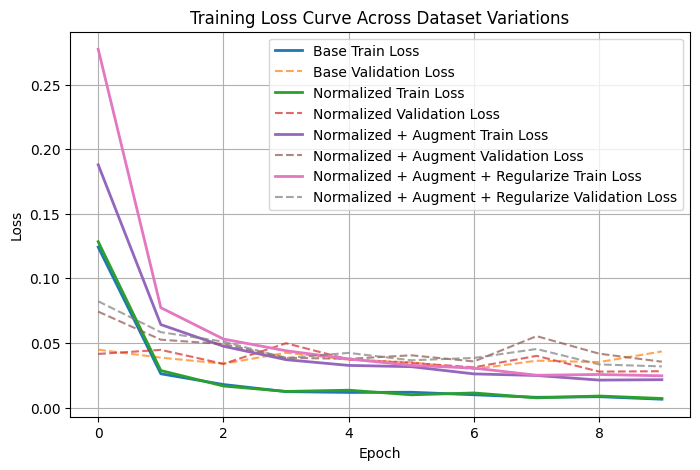

In [37]:
plt.figure(figsize=(8,5))
for variation_name, history in histories.items():
    plt.plot(history["val_acc"], label=f"{variation_name} Val Acc", linewidth=2)
    plt.plot(history["train_acc"], linestyle="--", alpha=0.7, label=f"{variation_name} Train Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Progress Across Dataset Variations")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
for variation_name, history in histories.items():
    plt.plot(history["train_loss"], label=f"{variation_name} Train Loss", linewidth=2)
    plt.plot(history["val_loss"], linestyle="--", alpha=0.7, label=f"{variation_name} Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve Across Dataset Variations")
plt.legend()
plt.grid(True)
plt.show()


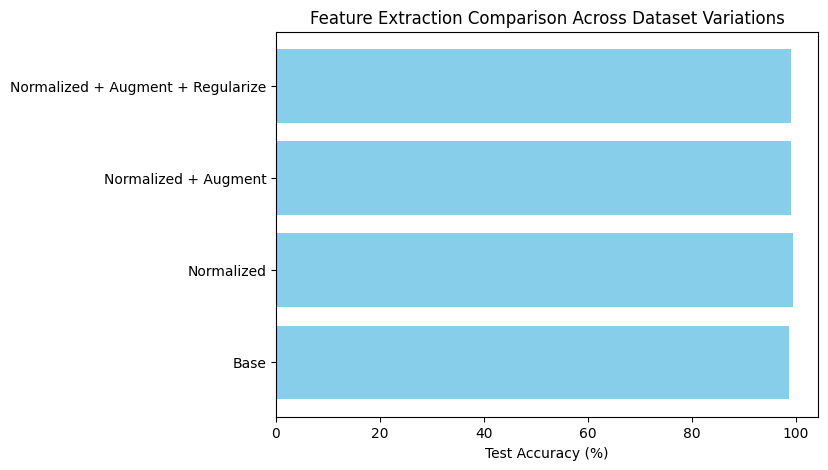

In [38]:
plt.figure(figsize=(7,5))
names = [r["Variation"] for r in results]
values = [r["Accuracy"] for r in results]
plt.barh(names, values, color='skyblue')
plt.xlabel("Test Accuracy (%)")
plt.title("Feature Extraction Comparison Across Dataset Variations")
plt.show()